# <center>Строим батчи на **pytorch**

In [1]:
import os
os.chdir("..")

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import os
# os.chdir('drive/My Drive/Colab Notebooks/neural_OTUS/project1_sp100')

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [28]:
from torch.utils.data import DataLoader, Dataset

#### Данные
загрузим ранее подготовленный датасет

In [6]:
path_to_data = "data"

In [7]:
features = pd.read_csv(os.path.join(path_to_data, "sp100.csv"), index_col=0)

In [8]:
features.head()

,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,...,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM,S&P100
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-18,0.928013,35.119999,15.150405,15.17,16.000000,1445.000000,24.0625,69.0625,38.4375,64.1250,...,11.093750,68.6875,23.4375,14.125,52.835213,29.2500,19.4375,65.5625,42.37500,795.679993
2000-01-19,0.951451,35.119999,14.841785,15.17,15.781250,1416.666626,23.5625,72.0000,39.0000,66.8125,...,10.906250,68.2500,23.0000,14.125,51.823475,30.1875,18.3750,64.0625,42.78125,790.309998
2000-01-20,1.013393,35.119999,14.392884,15.17,15.953125,1404.583374,23.7500,71.8125,40.5000,64.7500,...,10.500000,68.8750,22.1875,14.125,51.992096,30.1875,18.1875,63.3750,41.84375,783.330017
2000-01-21,0.993862,35.119999,14.000096,15.17,15.718750,1385.833374,23.5000,74.6875,43.1250,62.0625,...,10.937500,67.2500,21.6875,14.125,54.015572,29.9375,18.3125,62.4375,42.50000,779.780029
2000-01-24,0.948661,35.119999,13.467027,15.17,15.140625,1354.166626,22.8125,69.2500,42.0000,70.1250,...,10.609375,66.0000,21.4375,14.125,54.071781,29.0000,17.9375,59.3750,42.12500,758.739990


In [9]:
features.shape

(5198, 102)

Первые **4500** строк выделим под **обучение**, остальное - под **валидацию**

In [10]:
TRAIN_SPLIT = 4500

Посмотрим для наглядности на целевую переменную и некоторые курсы акций

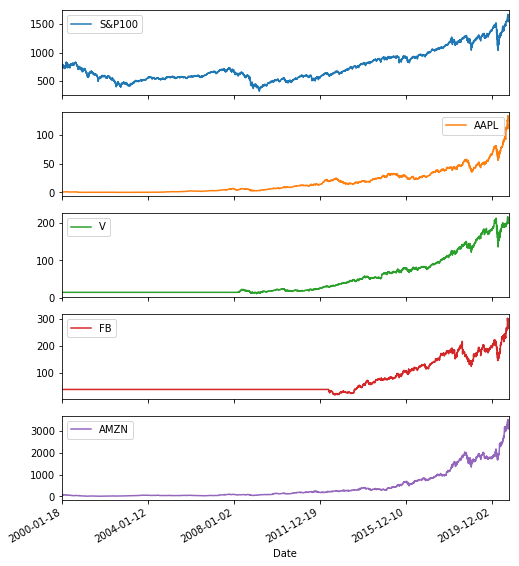

In [11]:
mpl.rcParams['figure.figsize'] = (8, 10)

tickers = ["S&P100", "AAPL", "V", "FB", "AMZN"]
features[tickers].plot(subplots=True);

In [12]:
features.shape

(5198, 102)

Стандартизируем (нормализуем) набор данных. Для расчета параметров стандартизации используем только **train**

In [13]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [14]:
dataset = (dataset-data_mean)/data_std

In [15]:
# dataset

## Точечное прогнозирование

In [16]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    """
    Функция организации временных интервалов
    """
    
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [17]:
past_history = 90  # смотрим историю за 90 дней (рабочих)
future_target = 1  # предсказываем следующий день
STEP = 1           # данные берем без пропусков

In [39]:
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, -1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, -1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [71]:
x_train_single.shape

(4410, 90, 102)

In [72]:
len(x_train_single)

4410

In [73]:
BATCH_SIZE = 16

In [106]:
class SP100Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, key):
        return self.x[key], self.y[key]

In [107]:
dataset_train = SP100Dataset(x_train_single, y_train_single)

In [108]:
dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True
                             )

In [109]:
for idx_batch, (x, y) in enumerate(dataloader_train):
    print(idx_batch, x.transpose(1, 0).shape, y.shape)

0 torch.Size([90, 16, 102]) torch.Size([16])
1 torch.Size([90, 16, 102]) torch.Size([16])
2 torch.Size([90, 16, 102]) torch.Size([16])
3 torch.Size([90, 16, 102]) torch.Size([16])
4 torch.Size([90, 16, 102]) torch.Size([16])
5 torch.Size([90, 16, 102]) torch.Size([16])
6 torch.Size([90, 16, 102]) torch.Size([16])
7 torch.Size([90, 16, 102]) torch.Size([16])
8 torch.Size([90, 16, 102]) torch.Size([16])
9 torch.Size([90, 16, 102]) torch.Size([16])
10 torch.Size([90, 16, 102]) torch.Size([16])
11 torch.Size([90, 16, 102]) torch.Size([16])
12 torch.Size([90, 16, 102]) torch.Size([16])
13 torch.Size([90, 16, 102]) torch.Size([16])
14 torch.Size([90, 16, 102]) torch.Size([16])
15 torch.Size([90, 16, 102]) torch.Size([16])
16 torch.Size([90, 16, 102]) torch.Size([16])
17 torch.Size([90, 16, 102]) torch.Size([16])
18 torch.Size([90, 16, 102]) torch.Size([16])
19 torch.Size([90, 16, 102]) torch.Size([16])
20 torch.Size([90, 16, 102]) torch.Size([16])
21 torch.Size([90, 16, 102]) torch.Size([16]